# Configuration

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

In [2]:
import sys, os

project_path = '../'
sys.path.append(project_path)

In [3]:
%load_ext autoreload
%autoreload 2

# Imports from environnement

In [4]:
from exploration.fall_study_stats import save_fractures_stats

# Reading DataFrames

In [18]:
import pandas as pd
import pyspark.sql.functions as fn

hospit = spark.read.parquet("/shared/Observapur/testing/featuring/hospitalized_fractures/data")
private_amb = spark.read.parquet("/shared/Observapur/testing/featuring/fractures/private_ambulatory_fractures/data")
public_amb = spark.read.parquet("/shared/Observapur/testing/featuring/fractures/public_ambulatory_fractures/data")
liberal = spark.read.parquet("/shared/Observapur/testing/featuring/fractures/liberal_fractures/data")

print("Uncessary filter")
outcomes = hospit.union(private_amb).union(public_amb).union(liberal)
outcomes = outcomes.filter(fn.col("start").between(pd.to_datetime('2011-01-01'), pd.to_datetime('2012-01-01')))

Uncessary filter


# Events Flowchart

In [6]:
from exploration.events_flowchart import build_events_flowchart

In [7]:
metadata_json = '''
{
  "class_name" : "fr.polytechnique.cmap.cnam.study.fall.FallMain$",
  "start_timestamp" : "2018-02-09T13:52:23Z",
  "end_timestamp" : "2018-02-09T14:04:58Z",
  "operations" : [ {
    "name" : "extract_patients",
    "inputs" : [ "source" ],
    "output_type" : "patients",
    "output_path" : "/shared/Observapur/testing/featuring/extract_patients/data"
  }, {
    "name" : "drug_purchases",
    "inputs" : [ "source" ],
    "output_type" : "dispensations",
    "output_path" : "/shared/Observapur/testing/featuring/drug_purchases/data",
    "population_path" : "/shared/Observapur/testing/featuring/drug_purchases/patients"
  }, {
    "name" : "acts",
    "inputs" : [ "source" ],
    "output_type" : "acts",
    "output_path" : "/shared/Observapur/testing/featuring/acts/data",
    "population_path" : "/shared/Observapur/testing/featuring/acts/patients"
  }, {
    "name" : "diagnoses",
    "inputs" : [ "source" ],
    "output_type" : "diagnosis",
    "output_path" : "/shared/Observapur/testing/featuring/diagnoses/data",
    "population_path" : "/shared/Observapur/testing/featuring/diagnoses/patients"
  }, {
    "name" : "filter_patients",
    "inputs" : [ "drug_purchases", "extract_patients" ],
    "output_type" : "patients",
    "output_path" : "/shared/Observapur/testing/featuring/filter_patients/data"
  }, {
    "name" : "exposures",
    "inputs" : [ "drug_purchases" ],
    "output_type" : "exposures",
    "output_path" : "/shared/Observapur/testing/featuring/exposures/data",
    "population_path" : "/shared/Observapur/testing/featuring/exposures/patients"
  }, {
    "name" : "liberal_acts",
    "inputs" : [ "acts" ],
    "output_type" : "acts",
    "output_path" : "/shared/Observapur/testing/featuring/liberal_acts/data",
    "population_path" : "/shared/Observapur/testing/featuring/liberal_acts/patients"
  }, {
    "name" : "liberal_fractures",
    "inputs" : [ "liberal_acts" ],
    "output_type" : "outcomes",
    "output_path" : "/shared/Observapur/testing/featuring/fractures/liberal_fractures/data",
    "population_path" : "/shared/Observapur/testing/featuring/fractures/liberal_fractures/patients"
  }, {
    "name" : "hospitalized_fractures",
    "inputs" : [ "diagnoses", "acts" ],
    "output_type" : "outcomes",
    "output_path" : "/shared/Observapur/testing/featuring/hospitalized_fractures/data",
    "population_path" : "/shared/Observapur/testing/featuring/hospitalized_fractures/patients"
  }, {
    "name" : "public_ambulatory_fractures",
    "inputs" : [ "acts" ],
    "output_type" : "outcomes",
    "output_path" : "/shared/Observapur/testing/featuring/fractures/public_ambulatory_fractures/data",
    "population_path" : "/shared/Observapur/testing/featuring/fractures/public_ambulatory_fractures/patients"
  }, {
    "name" : "private_ambulatory_fractures",
    "inputs" : [ "acts" ],
    "output_type" : "outcomes",
    "output_path" : "/shared/Observapur/testing/featuring/fractures/private_ambulatory_fractures/data",
    "population_path" : "/shared/Observapur/testing/featuring/fractures/private_ambulatory_fractures/patients"
  } ]
}
'''

In [20]:
flowchart_json = '''
{
    "intermediate_cohorts": {
        "outcome": ["hospitalized_fractures", "liberal_fractures",
             "public_ambulatory_fractures", "private_ambulatory_fractures"]
    },
    "steps": [
        "extract_patients",
        "exposures",
        "filter_patients"
    ]
}
'''

In [21]:
events = build_events_flowchart(outcomes, flowchart_json, metadata_json)

Constructing cohort for operation 'public_ambulatory_fractures'
Reading patients
Finished Reading
Constructing cohort for operation 'acts'
Reading patients
Finished Reading
Constructing cohort for operation 'liberal_fractures'
Reading patients
Finished Reading
Constructing cohort for operation 'extract_patients'
Reading patients
Finished Reading
Constructing cohort for operation 'hospitalized_fractures'
Reading patients
Finished Reading
Constructing cohort for operation 'exposures'
Reading patients
Finished Reading
Constructing cohort for operation 'filter_patients'
Reading patients
Finished Reading
Constructing cohort for operation 'diagnoses'
Reading patients
Finished Reading
Constructing cohort for operation 'drug_purchases'
Reading patients
Finished Reading
Constructing cohort for operation 'private_ambulatory_fractures'
Reading patients
Finished Reading
Constructing cohort for operation 'liberal_acts'
Reading patients
Finished Reading


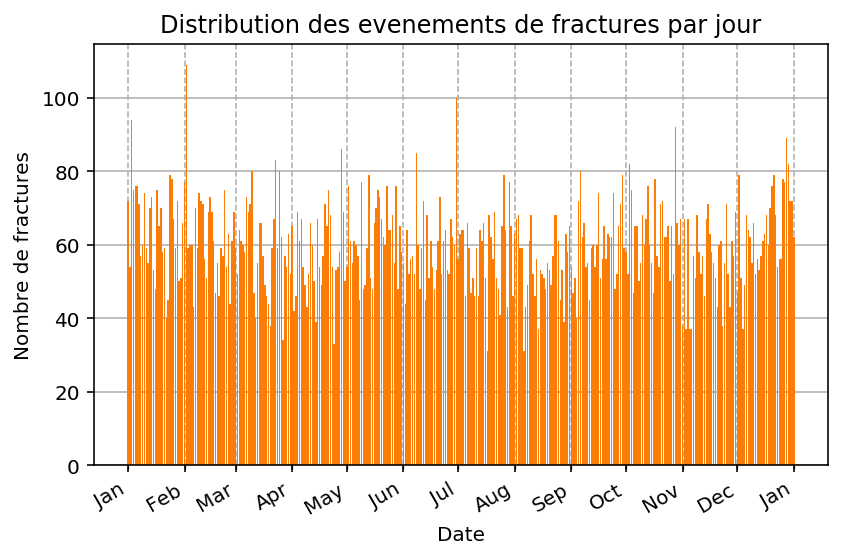

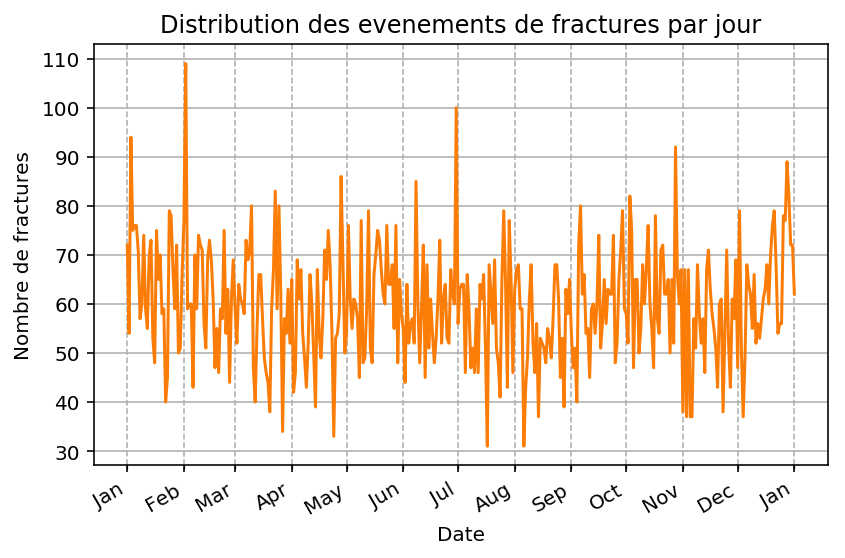

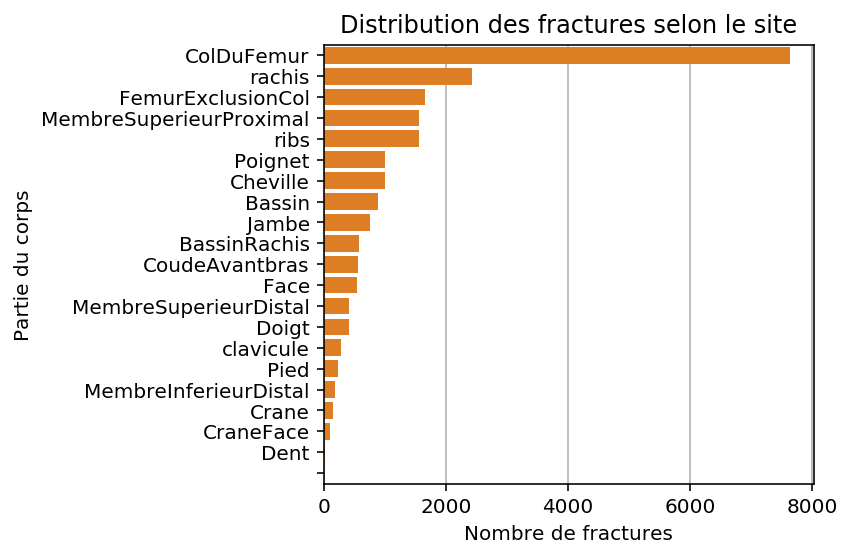

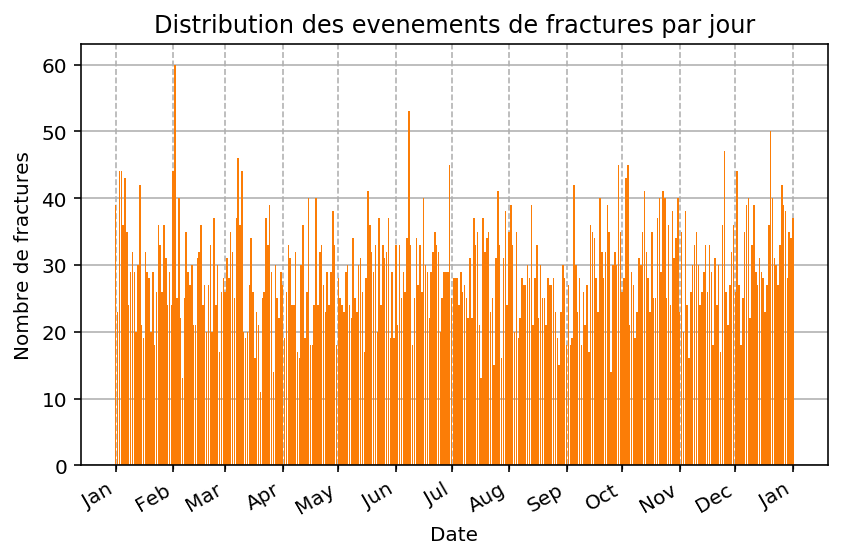

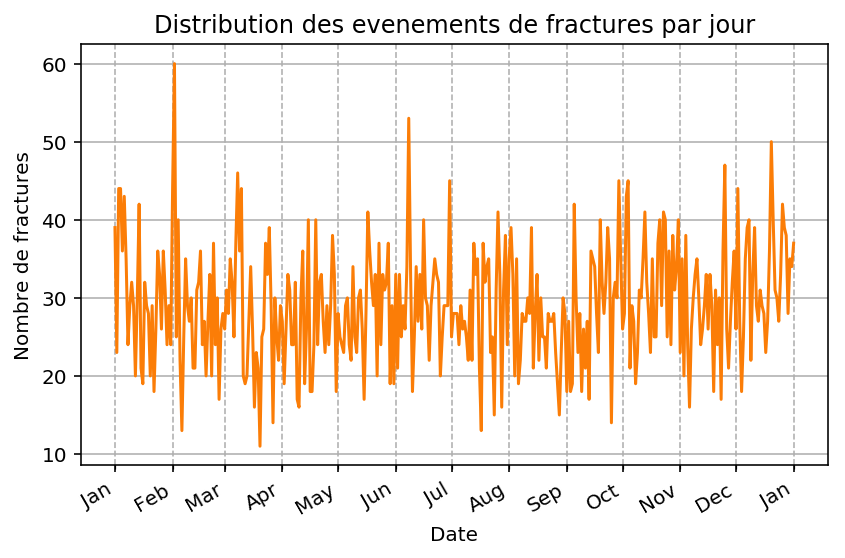

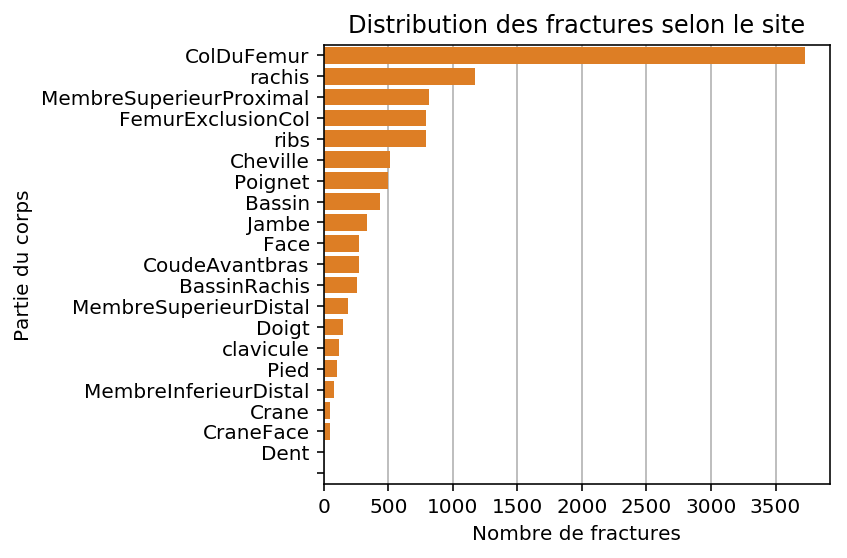

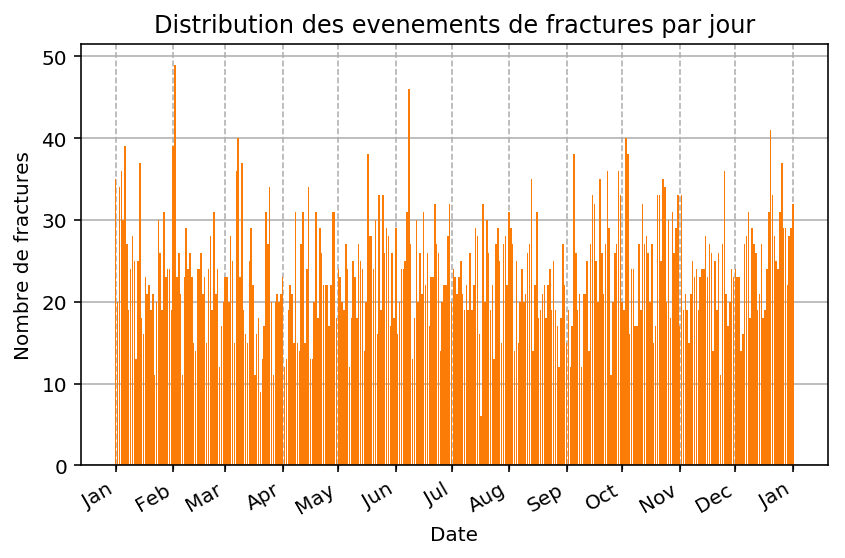

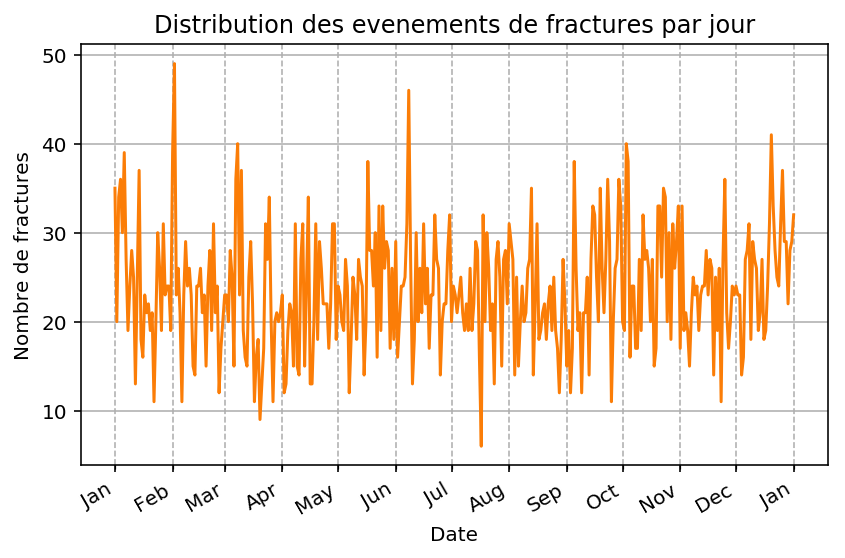

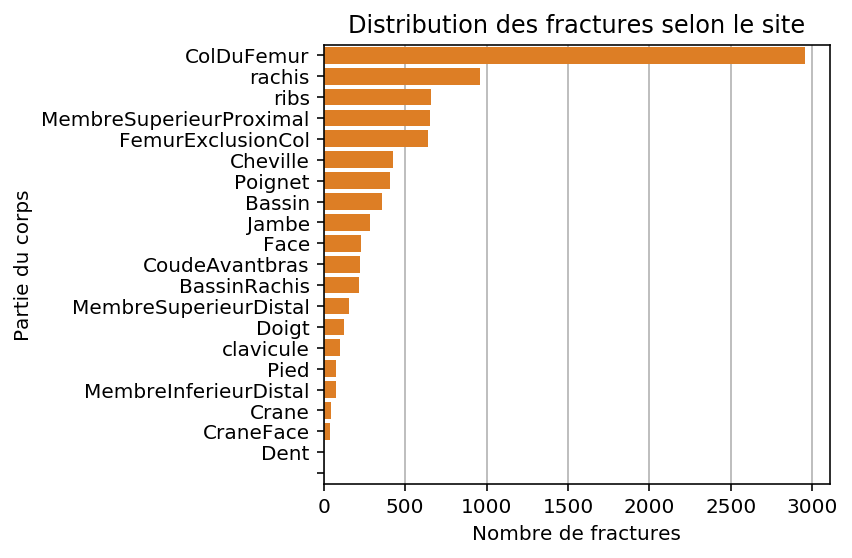

In [22]:
from os import path

root_path = "/home/sebiat/stats/CNAM-310"
for i, fractures in enumerate(events):
    file_path = path.join(root_path, "fractures_stats_apres_etape_{}".format(i))
    save_fractures_stats(file_path, fractures)